In [1]:
import anndata
import scanpy as sc
import pandas as pd

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

In [2]:
# this is an earlier version of the dataset from the pbmc3k tutorial
adata_ref = sc.datasets.pbmc3k_processed()
adata = sc.datasets.pbmc68k_reduced()

In [3]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names].copy()
adata = adata[:, var_names].copy()

In [4]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

/root/miniconda/envs/unified_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


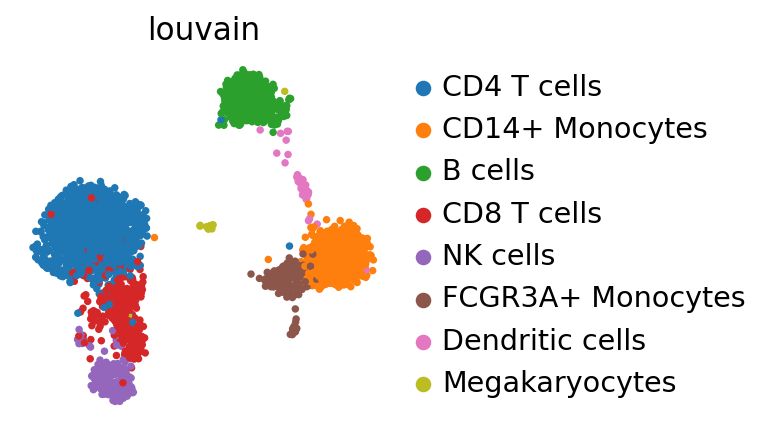

In [5]:
sc.pl.umap(adata_ref, color = "louvain")

/root/miniconda/envs/unified_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


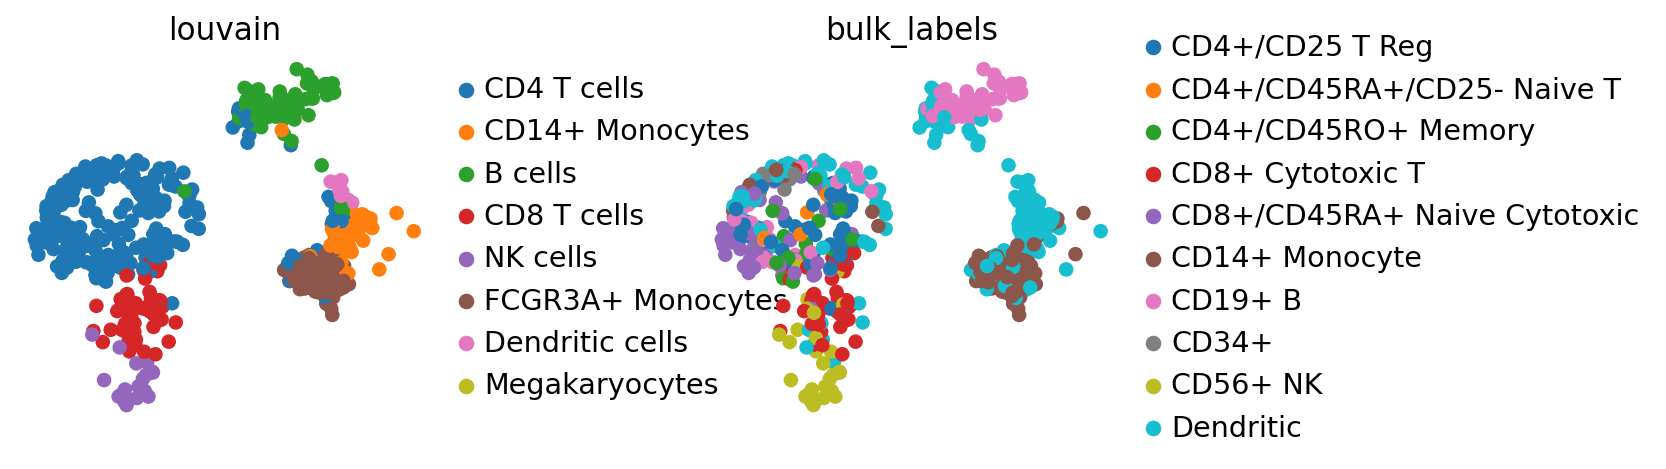

In [6]:
# Mapping PBMCs using ingest
## adata_ref의 label을 adata에 옮긴다

sc.tl.ingest(adata, adata_ref, obs = "louvain")
### adata_ref.obs["louvain"]을 adata.obs에 옮긴다.
### 따라서 adata_ref.obs["louvain"].cat.categories는 adata.obs ~~ 와 정확히 같은 값

adata.uns["louvain_colors"] = adata_ref.uns["louvain_colors"] #fix colors
### .uns : a dictionary-like attribute that stores unstructured metadata

sc.pl.umap(adata, color=["louvain", "bulk_labels"], wspace=0.5)
### "louvain" : sc.tl.louvain(adata)의 결과. adata 자체에서 clustering 돌린 것
### "bulk_labels" : 외부 라벨을 옮긴 것. 여기서는 ingest로 가져온 _ref의 라벨

## dendritic cell annotation이 이상한거 빼면 잘 합쳐짐

In [9]:
print(adata_ref.obs["louvain"].cat.categories)
print(adata.obs["louvain"].cat.categories)
print(type(adata.obs["louvain"].dtype))

# check if the indexes are mixed in order after running index

Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')
Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')
<class 'pandas.core.dtypes.dtypes.CategoricalDtype'>


In [17]:
# troubleshoot (concat error -> didn't work)
### 간단히 말해서, set_categories는 category list의 dtype만 바꾸지 
### 그 밑에 code나 value는 안바꿔서 그럼.
### 반면 pd.Categorical로 접근하면 아예 새로 만들어서 괜찮음

ref_cats = adata_ref.obs["louvain"].cat.categories

## set the datatype of .obs["louvain"] to pandas category and reorder
adata.obs["louvain"] = adata.obs["louvain"].astype("category")
adata.obs["louvain"] = adata.obs["louvain"].cat.set_categories(ref_cats)
print(adata_ref.obs["louvain"].cat.categories)
print(adata.obs["louvain"].cat.categories)

## check if the datatype's still not 'category'
print(adata_ref.obs["louvain"].dtype, adata.obs["louvain"].dtype)

## get rid of hidden labels
set(adata.obs["louvain"].unique()) - set(ref_cats)

Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')
Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')
category category


NameError: name 'adata_concat' is not defined

In [7]:
import pandas as pd

ref_cats = [str(c) for c in adata_ref.obs["louvain"].cat.categories]

# Force both to categorical with the exact same categories and dtype
adata_ref.obs["louvain"] = pd.Categorical(
    adata_ref.obs["louvain"].astype(str), categories=ref_cats
)
adata.obs["louvain"] = pd.Categorical(
    adata.obs["louvain"].astype(str), categories=ref_cats
)

### 원래의 .obs["louvain"]을 str로 바꿔서 ref_cats 순서로 정렬해라
### 이러면 concat 순서 안맞아서 생기는 버그가 해결됨

# Now concatenate
adata_concat = anndata.concat([adata_ref, adata], label="batch", keys=["ref", "new"])

In [8]:
adata_concat.obs["louvain"] = (
    adata_concat.obs["louvain"]
    .astype("category")
    .cat.reorder_categories(adata_ref.obs["louvain"].cat.categories)
)

### .astype("category") _ref와 adata의 louvain cluster가 순서가 다를 수 있음
### -> string이 아니라 pandas category type으로 다뤄 순서를 맞춘다
### .cat.reorder_categories(~~) : _ref의 순서로 .concat의 순서를 맞춘다. 

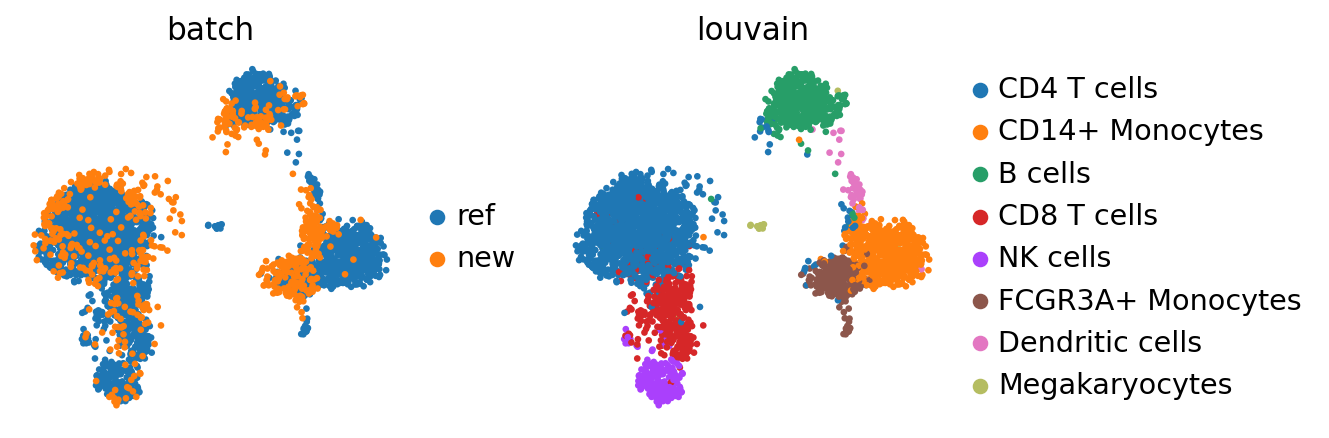

In [9]:
sc.pl.umap(adata_concat, color=["batch", "louvain"])

## CD4-CD8-NK처럼 섞이지 않고 batch가 분리되는 것 같으면 batch effect가 있다고 봄

In [10]:
adata_concat.raw = adata_concat.copy()

from pathlib import Path
Path("cache").mkdir(exist_ok = True)
adata_concat.write("cache/adata_concat.h5ad")